# Gait Cycle Analysis

## Data Collection Process

Data was collected using the Physics Toolbox Simulator app on a Samsung Galaxy Note. I collected data on the Linear Accelerometer, and standardized the way I put the phone in my pocket: with the top of the phone facing downwards, and the screen of the phone facing my leg. This way, each of the x, y, z directions were standardized. Overall, I ended up collecting about 5000 steps for each of the front and back pockets.

## Gait Cycle Extraction

We follow some steps of the method described in the paper for IDNet (https://arxiv.org/pdf/1606.03238.pdf). We first interpolate each of the signals, because the sampling rate is irregular (the android sensors take measurements based off of change in the signal). Then, we pass the signals through a lowpass filter with cutoff frequency 40Hz, compute the magnitude across the x, y, z directions, and pass the magnitude signal through a lowpass filter with cutoff frequency 3Hz. The local minima of this processed signal represent the heel strikes, so taking the interval of every other minima gives the gait cycles. 

The motivation for this is that steps occur much less frequent than 3Hz, so the portion of the signal that indicates where the steps begin would be more prominient after filtering out higher frequencies.

I did not feel the need to implement the other methods described (template matching/update, calculating cross coorelation) because my data had relatively regular walking patterns and looking at the minima seemed to be enough.

I also considered the method described here (http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4272626) but found that their method yielded a lot of false positives for me. My signals were noisier and had a lot of "fake" local minima.

Furthermore, I considered training an RNN to extract out the boundaries between gait cycles. However, it was difficult to label a lot of data manually. It also didn't make much sense to use a ML method when there was an easy and robust way to extract out the cycles using basic signal processing.

In [3]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, firwin, lfilter, argrelmin
from random import shuffle
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd.variable import Variable
from torch.utils.data import Dataset, DataLoader

In [60]:
signals = [[], [], [], [], []]  # time, x, y, z, magnitude

with open('frontpocket_data/frontpocket_validation.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    index = 0
    # Due to rounding errors, some seconds come out the same.
    # We take the first of the two measurements
    last_second = -1
    for line in reader:
        if not index == 0:
            nums = [float(x) for x in line]
            if not nums[0] == last_second:
                signals[0].append(nums[0])
                signals[1].append(nums[1])
                signals[2].append(nums[2])
                signals[3].append(nums[3])
                last_second = nums[0]
        index += 1
    print(len(signals[0]))

260162


In the beginning and end of each walking session, I stood still for a couple seconds. I visualized the signal at the beginning and the end to find where these intervals began and started. Then, I manually cut these parts out to get just the walking signal.

260162


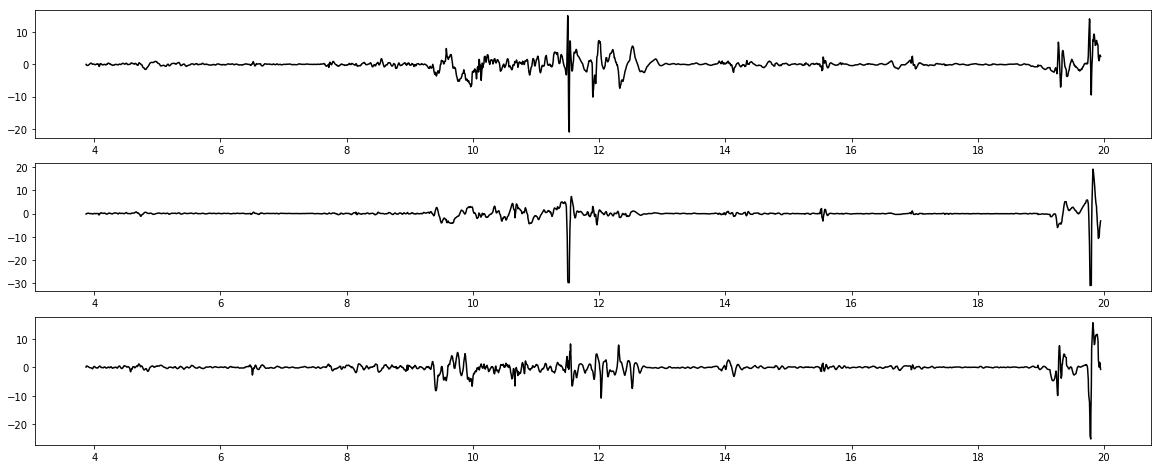

In [256]:
fig = plt.figure(figsize=(20, 8))
print(len(signals[0]))
index1, index2 = (0, 3200)
ax = fig.add_subplot(311)
ax.plot(signals[0][index1:index2], signals[1][index1:index2], 'k')
bx = fig.add_subplot(312)
bx.plot(signals[0][index1:index2], signals[2][index1:index2], 'k')
cx = fig.add_subplot(313)
cx.plot(signals[0][index1:index2], signals[3][index1:index2], 'k')
plt.show()

After truncating the signal to the walking portions, I interpolated the signal and resampled it to 200 times per second. 

In [61]:
#start_index, end_index = (800, 2600)  # front pocket 4 steps
#start_index, end_index = (400, 25430)  # front pocket gates
#start_index, end_index = (1375, 47600)  # front pocket 1
#start_index, end_index = (1280, 47500)  # front pocket 2
#start_index, end_index = (1200, 25100)  # front pocket 3
#start_index, end_index = (1200, 18800)  # back pocket 1
#start_index, end_index = (970, 46250)  # back pocket 2

start_index, end_index = (3150, 257800)  # front pocket validation
#start_index, end_index = (3100, 264750)  # back pocket validation

num_samples = int(200 * (signals[0][end_index] - signals[0][start_index]))

xnew = np.linspace(signals[0][start_index], signals[0][(end_index-1)], num=num_samples, endpoint=True)
interp1 = interp1d(np.array(signals[0][start_index:end_index]), np.array(signals[1][start_index:end_index]),
                  kind='linear')
interp2 = interp1d(np.array(signals[0][start_index:end_index]), np.array(signals[2][start_index:end_index]),
                  kind='linear')
interp3 = interp1d(np.array(signals[0][start_index:end_index]), np.array(signals[3][start_index:end_index]),
                  kind='linear')
i_signals = [xnew, interp1(xnew), interp2(xnew), interp3(xnew)]

In [62]:
def norm(x_list):
    return math.sqrt(sum(i**2 for i in x_list))

# credit: https://github.com/vinayprabhu/Walk-cycles-and-accelerometry
def lowpass_filter_butterworth(x_in, f_c=40, f_s=200, order=5):
    b, a = butter(order, f_c/ (0.5 * f_s), btype='low', analog=False)
    x_out = filtfilt(b, a, x_in)
    return x_out

#def lowpass_filter_fir(x_in, sample_rate, cutoff_f, trans_width=5.0, ripple_db=60.0):
#    nyq_rate = sample_rate / 2.0
#    width = trans_width / nyq_rate
#    N, beta = kaiserord(ripple_db, width)
#    
#    taps = firwin(N, cutoff_f / nyq_rate, window=('kaiser', beta))
#    x_out = lfilter(taps, 1.0, x_in)
#    return x_out

i_signals[1] = lowpass_filter_butterworth(i_signals[1], 40, 200, 5)
i_signals[2] = lowpass_filter_butterworth(i_signals[2], 40, 200, 5)
i_signals[3] = lowpass_filter_butterworth(i_signals[3], 40, 200, 5)
#filter_signal = lowpass_filter_fir(interp_signal, 200, 40)

norms = [norm([i_signals[1][i], i_signals[2][i], i_signals[3][i]]) for i in range(len(i_signals[0]))]
i_signals.append(norms)

filtered_norms = lowpass_filter_butterworth(norms, 3, 200, 5)

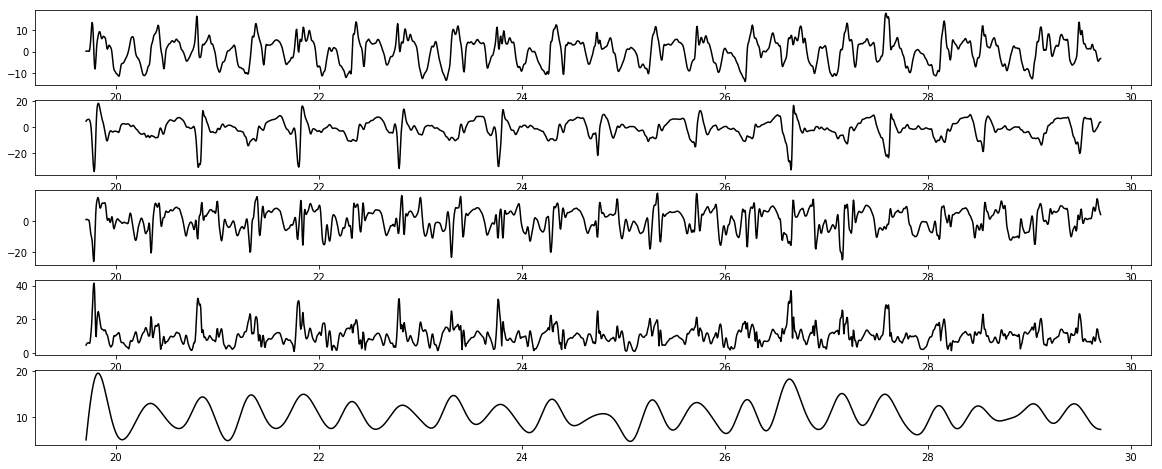

In [259]:
fig = plt.figure(figsize=(20, 8))
index1, index2 = (0, 2000)
ax = fig.add_subplot(511)
ax.plot(i_signals[0][index1:index2], i_signals[1][index1:index2], 'k')
bx = fig.add_subplot(512)
bx.plot(i_signals[0][index1:index2], i_signals[2][index1:index2], 'k')
cx = fig.add_subplot(513)
cx.plot(i_signals[0][index1:index2], i_signals[3][index1:index2], 'k')
dx = fig.add_subplot(514)
dx.plot(i_signals[0][index1:index2], i_signals[4][index1:index2], 'k')
ex = fig.add_subplot(515)
ex.plot(i_signals[0][index1:index2], filtered_norms[index1:index2], 'k')
plt.show()

As visualized from the plots, the minima of the processed magnitude signal (bottom) does indeed coorespond with the start of every step. Thus, we take these minima, and take the gait cycles to be the sections between every other minima.

In [63]:
mins = argrelmin(filtered_norms)[0]
print(mins.shape)
print(mins[0])
interval_sizes = [mins[i+2]- mins[i] for i in range(0, mins.size - 2, 2)]
print(interval_sizes[:10])

(3047,)
71
[208, 204, 197, 193, 199, 189, 182, 195, 162, 199]


Finally, we take each of these gait cycles, and resample them to 200 points again (each of the cycles is approximately 200 samples, or 1 second long). We write the signal from the x, y, z, and norm into each line of a csv, resulting in samples with 4 * 200 = 800 entries each.

In [262]:
new_interp1 = interp1d(np.array(i_signals[0]), np.array(i_signals[1]), kind='linear')
new_interp2 = interp1d(np.array(i_signals[0]), np.array(i_signals[2]), kind='linear')
new_interp3 = interp1d(np.array(i_signals[0]), np.array(i_signals[3]), kind='linear')

with open('frontpocket_validation_filtered.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    for i in range(0, mins.size - 2, 2):
        new_t = np.linspace(i_signals[0][mins[i]], i_signals[0][mins[i+2]], 200, endpoint=False)
        new_x = new_interp1(new_t)
        new_y = new_interp2(new_t)
        new_z = new_interp3(new_t)
        new_norm = np.array([norm([new_x[i], new_y[i], new_z[i]]) for i in range(200)])
        tensor = np.concatenate((new_x, new_y, new_z, new_norm))
        csvwriter.writerow(tensor)

Afterwards, we split the dataset into train/test, with a 90/10 split. We balance both of these datasets to have the same proportion of front/back pocket examples.

In [271]:
# Shuffle the data and split into train/test
# Add an extra entry to each line, 0 if front pocket, 1 for back pocket
def writecsv(data, csvpath):
    with open(csvpath, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        for x in data:
            csvwriter.writerow(x)

with open('frontpocket.csv', 'r') as frontcsv:
    with open('backpocket.csv', 'r') as backcsv:
        frontreader = csv.reader(frontcsv)
        backreader = csv.reader(backcsv)
        
        frontdata = []
        backdata = []
        for line in frontreader:
            line.append('0')
            frontdata.append(line)
        for line in backreader:
            line.append('1')
            backdata.append(line)
        shuffle(frontdata)
        shuffle(backdata)
        
        front_idx = (len(frontdata) * 9) // 10
        back_idx = (len(backdata) * 9) // 10
        
        writecsv(frontdata[:front_idx], 'frontpocket_train.csv')
        writecsv(frontdata[front_idx:], 'frontpocket_test.csv')
        writecsv(backdata[:back_idx], 'backpocket_train.csv')
        writecsv(backdata[back_idx:], 'backpocket_test.csv')
        
        train_data = frontdata[:front_idx] + backdata[:back_idx]
        test_data = frontdata[front_idx:] + backdata[back_idx:]
        
        writecsv(train_data, 'train.csv')
        writecsv(test_data, 'test.csv')

## Style Transfer

There were four main approaches that I considered for style transfer. 

The first is a network, most likely an encoder/decoder network with convolutions/deconvolution layers would transform front pocket signal to its cooresponding back pocket signal and vice versa, trained with supervised learning. This would most likely work pretty well, but requires the data to have both the front pocket and back pocket signal for each particular step, which I didn't have and don't see as a scalable, long-term solution.

The second is CycleGAN (https://arxiv.org/pdf/1703.10593.pdf), which performs translation between data from unpaired domains. It does this by learning mappings between domains X, Y, F: X -> Y and G: Y -> X as GANs, with the additional condition that G(F(x)) = x, and F(G(y)) = y. I did not take this approach because CycleGAN has had inconsistent levels of success in just the image domain, and in my experience, GAN's are very tricky to train and could take weeks to debug/tune parameters.

The third is using whitening and coloring transforms on the feature space (https://arxiv.org/pdf/1705.08086.pdf). The idea is that instead of training a network for a particular style, you train a single encoder/decoder network. Then, in order to produce an image of a different style, you do whitening and coloring transformations on the encoded feature map. This gives you the ability to transfer between many different types of styles with no additional cost in training time. However, this method loses out to other style transfer methods in terms of performance.

The fourth method, and the method that I ended up using, is based off of image stylization by Johnson et. al (https://arxiv.org/pdf/1603.08155.pdf). They train a transformation network, that takes in an input image and a target style image, and outputs a stylized version of the input image. This network is optimized for perceptual losses, which are derived from features maps after passing the input/style image through a pretrained network on images. They compute a content loss from the difference between the feature maps, and a style loss from the difference in the Gram Matrix of the feature maps.

In this case, I train my own loss network on the task of classifying signals of front/back pocket. Then, I train my transformer network on the content/style losses on this network. Hopefully, the features maps given by intermediate layers of the classifier abstract useful features.

First, we prepare the data into a PyTorch dataloader.

In [4]:
class GaitDataset(Dataset):
    def __init__(self, num_samples, dataset_file):
        self.num_samples = num_samples
        
        self.data = []
        with open(dataset_file, 'r') as data:
            csvreader = csv.reader(data)
            for line in csvreader:
                line = [float(x) for x in line]
                self.data.append(line)
                
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        line = self.data[idx]
        signal = np.reshape(np.array(line[:800]), (4, 200))
        signal = np.expand_dims(signal, axis=0)
        label = np.array([line[-1]])

        sample = {'signal': np.array(signal), 'label': label}
        
        return sample
    
traindata = GaitDataset(4713, 'train.csv')
testdata = GaitDataset(525, 'test.csv')
front_traindata = GaitDataset(2769, 'frontpocket_train.csv')
front_testdata = GaitDataset(308, 'frontpocket_test.csv')
back_traindata = GaitDataset(1944, 'backpocket_train.csv')
back_testdata = GaitDataset(217, 'backpocket_test.csv')
dataloader = DataLoader(traindata, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testdata, batch_size=525)
front_dataloader = DataLoader(front_traindata, batch_size=32)
fronttest_dataloader = DataLoader(front_testdata, batch_size=1)
back_dataloader = DataLoader(back_traindata, batch_size=32)
backtest_dataloader = DataLoader(back_testdata, batch_size=1)

Our loss network roughly follows the architecture of the network in IDNet (https://arxiv.org/pdf/1606.03238.pdf). I first run convolutions over each of the signals separately, and then convolutions across the signals to capture cross correlation. I took out the maxpooling layer, because the network is small enough without it, and I found it hinders performance in my experiments.

In [5]:
# Parent neural net module
class NeuralNet(nn.Module):
    def load_weights(self, weight_file, use_gpu=True):
        if use_gpu:
            weights = torch.load(weight_file)
        else:
            weights = torch.load(weight_file,
                                 map_location=lambda storage,
                                 loc: storage)
        self.load_state_dict(weights)
        print('Model loaded:\n %s' % weight_file)
        
    def save_weights(self, weight_file):
        torch.save(self.state_dict(), weight_file)
        print('Model weights saved:\n %s' % weight_file)
        

class IDNetCNN(NeuralNet):
    def __init__(self):
        super(IDNetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, (1, 11), padding=(0, 5))
        self.conv2 = nn.Conv2d(20, 40, (3, 11), padding=(1, 5))
        #self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(40 * 4 * 200, 40)
        self.fc2 = nn.Linear(40, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.tanh(self.conv2(x))
        #x = self.pool1(x)
        x = x.view(-1, 40 * 4 * 200)
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x       

Now, we train the network to classify signals as front/back pocket using cross entropy loss and the Adam optimizer. The network converges fairly quickly and gets to 100% accuracy on the validation set.

In [74]:
idnet = IDNetCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(idnet.parameters(), lr=0.001)

for epoch in range(20):
    running_loss = 0.0
    for i_batch, sample_batched in enumerate(dataloader):
        signals = sample_batched['signal'].cuda()
        labels = sample_batched['label'].cuda()
        labels = labels.view(-1)
        
        signals = Variable(signals).float()
        labels = Variable(labels).long()
        
        idnet.zero_grad()
        
        outputs = idnet(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i_batch % 10 == 9:
            # print(outputs)
            print('[%d, %d] loss: %.3f' %
                  (epoch + 1, i_batch + 1, running_loss / 10))
            running_loss = 0.0

    # Calculate the accuracy over the validation set
    for _, validate_batch in enumerate(test_dataloader):
        batch = validate_batch['signal'].cuda()
        labels = validate_batch['label'].cuda()
        labels = labels.view(-1)
        
        batch = Variable(batch).float()
        labels = Variable(labels).long()
        
        outputs = idnet(batch)
        max_index = outputs.max(dim=1)[1]
        num_correct = (max_index==labels).int().sum()
        print('Accuracy: %.3f' % (num_correct.data[0] / 525))
        
idnet.save_weights('classify_net.pth')

[1, 10] loss: 0.628
[1, 20] loss: 0.373
[1, 30] loss: 0.342
[1, 40] loss: 0.335
[1, 50] loss: 0.327
[1, 60] loss: 0.327
[1, 70] loss: 0.330
[1, 80] loss: 0.326
[1, 90] loss: 0.321
[1, 100] loss: 0.330
[1, 110] loss: 0.326
[1, 120] loss: 0.330
[1, 130] loss: 0.332
[1, 140] loss: 0.325
Accuracy: 0.994
[2, 10] loss: 0.327
[2, 20] loss: 0.317
[2, 30] loss: 0.319
[2, 40] loss: 0.317
[2, 50] loss: 0.318
[2, 60] loss: 0.318
[2, 70] loss: 0.318
[2, 80] loss: 0.325
[2, 90] loss: 0.325
[2, 100] loss: 0.320
[2, 110] loss: 0.322
[2, 120] loss: 0.324
[2, 130] loss: 0.321
[2, 140] loss: 0.323
Accuracy: 0.994
[3, 10] loss: 0.316
[3, 20] loss: 0.317
[3, 30] loss: 0.317
[3, 40] loss: 0.319
[3, 50] loss: 0.318
[3, 60] loss: 0.320
[3, 70] loss: 0.320
[3, 80] loss: 0.322
[3, 90] loss: 0.316
[3, 100] loss: 0.317
[3, 110] loss: 0.315
[3, 120] loss: 0.320
[3, 130] loss: 0.320
[3, 140] loss: 0.320
Accuracy: 0.998
[4, 10] loss: 0.320
[4, 20] loss: 0.317
[4, 30] loss: 0.317
[4, 40] loss: 0.318
[4, 50] loss: 0.3

Now, we define a class that has the same architecure of IDNet, but returns the features maps of the convolutional layers. Furthermore, we define a transformation network, that first downsamples with a series of convolutions, and upsamples with deconvolutions. Due to rounding errors, the final dimension of this tensor is B x 1 x 4 x 199, so we use bilinear interpolation to bring this up to B x 1 x 4 x 200. 

In [22]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = torch.bmm(features, features_t) / (ch * h * w)
    return gram

class IDNetFeatures(IDNetCNN):
    def __init__(self):
        super(IDNetFeatures, self).__init__()
        for param in self.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        conv1 = x
        x = F.tanh(self.conv2(x))
        conv2 = x
        x = x.view(-1, 40 * 4 * 200)
        x = F.tanh(self.fc1(x))
        fc1 = x
        x = F.softmax(self.fc2(x))
        fc2 = x
        features = namedtuple("features", ['conv1', 'conv2'])
        out = features(conv1, conv2)
        return out
    
class Transformer(NeuralNet):
    def __init__(self):
        super(Transformer, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, (1, 11), padding=(0, 5))
        self.conv2 = nn.Conv2d(20, 40, (3, 11), stride=(1, 3),
                               padding = (1, 5))
        self.conv3 = nn.Conv2d(40, 80, (3, 11), stride=(1, 3),
                               padding = (1, 5))
        self.deconv1 = nn.ConvTranspose2d(80, 40, (3, 11), stride=(1, 3),
                                          padding=(1, 5))
        self.conv4 = nn.Conv2d(40, 40, (1, 11), padding=(0, 5))
        self.deconv2 = nn.ConvTranspose2d(40, 20, (3, 11), stride=(1, 3),
                                          padding=(1, 5))
        self.conv5 = nn.Conv2d(20, 20, (1, 11), padding=(0, 5))
        self.deconv3 = nn.ConvTranspose2d(20, 1, (1, 11), padding=(0, 5))
        self.upsample = nn.UpsamplingBilinear2d(size=(4, 200))
#         self.conv1 = nn.Conv2d(1, 20, (1, 11), padding = (0, 5))
#         self.conv2 = nn.Conv2d(20, 40, (1, 11), padding = (0, 5))
#         self.conv3 = nn.Conv2d(40, 80, (3, 11), padding = (1, 5))
#         self.conv4 = nn.Conv2d(80, 40, (3, 11), padding = (1, 5))
#         self.conv5 = nn.Conv2d(40, 20, (3, 11), padding = (1, 5))
#         self.conv6 = nn.Conv2d(20, 1, (3, 11), padding = (1, 5))
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        x = self.upsample(x)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.conv6(x)
        return x

Now, we train our transformer network on the content loss and the style loss. We first train a transformer specifically for back pocket signals to front pocket signals.

In [30]:
front_target = next(enumerate(fronttest_dataloader))[1]['signal']

idnet_features = IDNetFeatures().cuda()
idnet_features.load_weights('classify_net.pth')

front_target = Variable(front_target.cuda()).float()

features_style_front = idnet_features(front_target.float())
gram_style_front = [gram_matrix(y) for y in features_style_front]
gram_style_front[0] = gram_style_front[0].repeat(32, 1, 1)
gram_style_front[1] = gram_style_front[1].repeat(32, 1, 1)

f_transformer = Transformer().cuda()
optimizer = optim.Adam(f_transformer.parameters(), lr=0.0001)
mse_loss = torch.nn.MSELoss()

content_weight = 1
style_weight = 1

for epoch in range(41):
    running_content_loss = 0.0
    running_style_loss = 0.0
    for i_batch, sampled_batch in enumerate(back_dataloader):
        signals = sampled_batch['signal'].cuda()
        signals = Variable(signals.cuda()).float()
        
        y = f_transformer(signals)
        
        features_y = idnet_features(y)
        features_x = idnet_features(signals)
        
        content_loss = mse_loss(features_y.conv2, features_x.conv2) +\
                       mse_loss(features_y.conv1, features_x.conv1)
        content_loss *= content_weight
        
        style_loss = 0.0
        for ft_y, gm_s in zip(features_y, gram_style_front):
            gm_y = gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:signals.size()[0], :, :])
        style_loss *= style_weight
        
        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()
        
        running_content_loss += content_loss.data[0]
        running_style_loss += style_loss.data[0]
        
        if epoch % 5 == 0 and i_batch % 10 == 9:
            print('[%d, %d] content loss: %.3f  style loss: %.3f' %
                  (epoch + 1, i_batch + 1, running_content_loss / 10, running_style_loss / 10))
        
f_transformer.save_weights('front_transformer_weights.pth')

Model loaded:
 classify_net.pth
[1, 10] content loss: 12.503  style loss: 0.302


/home/phillip/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


[1, 20] content loss: 24.816  style loss: 0.601
[1, 30] content loss: 36.380  style loss: 0.803
[1, 40] content loss: 47.475  style loss: 0.998
[1, 50] content loss: 59.161  style loss: 1.298
[1, 60] content loss: 71.311  style loss: 1.599
[6, 10] content loss: 11.741  style loss: 0.300
[6, 20] content loss: 23.518  style loss: 0.599
[6, 30] content loss: 34.822  style loss: 0.896
[6, 40] content loss: 45.854  style loss: 1.190
[6, 50] content loss: 56.411  style loss: 1.476
[6, 60] content loss: 66.209  style loss: 1.748
[11, 10] content loss: 7.915  style loss: 0.141
[11, 20] content loss: 15.648  style loss: 0.297
[11, 30] content loss: 23.203  style loss: 0.478
[11, 40] content loss: 30.579  style loss: 0.673
[11, 50] content loss: 37.682  style loss: 0.872
[11, 60] content loss: 44.252  style loss: 1.060
[16, 10] content loss: 4.803  style loss: 0.081
[16, 20] content loss: 9.131  style loss: 0.183
[16, 30] content loss: 13.587  style loss: 0.337
[16, 40] content loss: 18.471  sty

Then, we train a transformer from front pocket signals to back pocket signals.

In [41]:
back_target = next(enumerate(backtest_dataloader))[1]['signal']

back_target = Variable(back_target.cuda()).float()

features_style_back = idnet_features(back_target.float())
gram_style_back = [gram_matrix(y) for y in features_style_back]
gram_style_back[0] = gram_style_back[0].repeat(32, 1, 1)
gram_style_back[1] = gram_style_back[1].repeat(32, 1, 1)

b_transformer = Transformer().cuda()
optimizer = optim.Adam(b_transformer.parameters(), lr=0.0001)
mse_loss = torch.nn.MSELoss()

content_weight = 10
style_weight = 10

for epoch in range(41):
    running_content_loss = 0.0
    running_style_loss = 0.0
    for i_batch, sampled_batch in enumerate(front_dataloader):
        signals = sampled_batch['signal'].cuda()
        signals = Variable(signals.cuda()).float()
        
        y = b_transformer(signals)
        
        features_y = idnet_features(y)
        features_x = idnet_features(signals)
        
        content_loss = mse_loss(features_y.conv2, features_x.conv2)
        content_loss *= content_weight
        
        style_loss = 0.0
        for ft_y, gm_s in zip(features_y, gram_style_front):
            gm_y = gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:signals.size()[0], :, :])
        style_loss *= style_weight
        
        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()
        
        running_content_loss += content_loss.data[0]
        running_style_loss += style_loss.data[0]
        
        if epoch % 5 == 0 and i_batch % 10 == 9:
            print('[%d, %d] content loss: %.3f  style loss: %.3f' %
                  (epoch + 1, i_batch + 1, running_content_loss / 10, running_style_loss / 10))
        
b_transformer.save_weights('back_transformer_weights.pth')

/home/phillip/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


[1, 10] content loss: 8.067  style loss: 3.015
[1, 20] content loss: 15.316  style loss: 6.018
[1, 30] content loss: 22.647  style loss: 8.981
[1, 40] content loss: 29.842  style loss: 11.992
[1, 50] content loss: 36.523  style loss: 15.005
[1, 60] content loss: 42.295  style loss: 17.991
[1, 70] content loss: 49.233  style loss: 20.733
[1, 80] content loss: 56.526  style loss: 22.917
[6, 10] content loss: 5.106  style loss: 1.822
[6, 20] content loss: 12.131  style loss: 3.839
[6, 30] content loss: 19.848  style loss: 5.929
[6, 40] content loss: 27.658  style loss: 8.082
[6, 50] content loss: 35.108  style loss: 10.323
[6, 60] content loss: 41.874  style loss: 12.701
[6, 70] content loss: 47.975  style loss: 15.185
[6, 80] content loss: 53.507  style loss: 17.789
[11, 10] content loss: 4.563  style loss: 2.832
[11, 20] content loss: 9.259  style loss: 5.766
[11, 30] content loss: 14.194  style loss: 8.745
[11, 40] content loss: 19.586  style loss: 11.742
[11, 50] content loss: 25.380 

Now we visualize some back signals, and their cooresponding stylized front signals. We specifically visualize the magnitudes of the x, y, z accelerometer measurements at each point.

Model loaded:
 front_transformer_weights.pth


/home/phillip/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


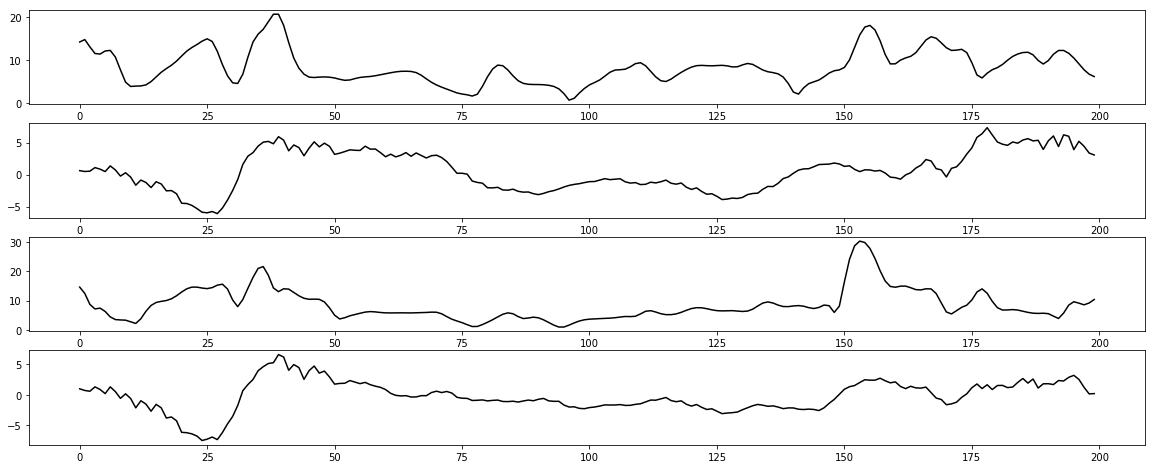

In [33]:
back_to_front_transformer = Transformer()
back_to_front_transformer.load_weights('front_transformer_weights.pth')

temp = enumerate(backtest_dataloader)
back1 = next(temp)[1]['signal'].numpy()
back2 = next(temp)[1]['signal'].numpy()
mag1 = np.resize(back1[0, 0, 3, :], (200))
mag2 = np.resize(back2[0, 0, 3, :], (200))
trans_mag1 = back_to_front_transformer(Variable(torch.from_numpy(back1)).float())
trans_mag1 = np.resize(trans_mag1.data.numpy(), (200))
trans_mag2 = back_to_front_transformer(Variable(torch.from_numpy(back2)).float())
trans_mag2 = np.resize(trans_mag2.data.numpy(), (200))

x_values = [i for i in range(200)]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(411)
ax.plot(x_values, mag1, 'k')
bx = fig.add_subplot(412)
bx.plot(x_values, trans_mag1, 'k')
cx = fig.add_subplot(413)
cx.plot(x_values, mag2, 'k')
dx = fig.add_subplot(414)
dx.plot(x_values, trans_mag2, 'k')
plt.show()

Similarly, we visualize some front signals, and their cooresponding back signals.

Model loaded:
 back_transformer_weights.pth


/home/phillip/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


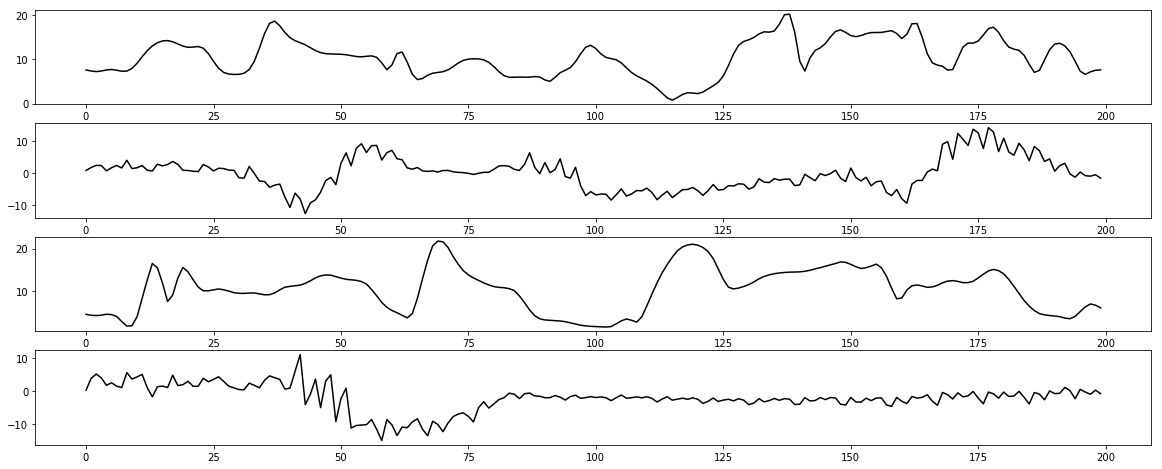

In [42]:
front_to_back_transformer = Transformer()
front_to_back_transformer.load_weights('back_transformer_weights.pth')

temp = enumerate(fronttest_dataloader)
front1 = next(temp)[1]['signal'].numpy()
front2 = next(temp)[1]['signal'].numpy()
mag1 = np.resize(front1[0, 0, 3, :], (200))
mag2 = np.resize(front2[0, 0, 3, :], (200))
trans_mag1 = front_to_back_transformer(Variable(torch.from_numpy(front1)).float())
trans_mag1 = np.resize(trans_mag1.data.numpy(), (200))
trans_mag2 = front_to_back_transformer(Variable(torch.from_numpy(front2)).float())
trans_mag2 = np.resize(trans_mag2.data.numpy(), (200))

x_values = [i for i in range(200)]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(411)
ax.plot(x_values, mag1, 'k')
bx = fig.add_subplot(412)
bx.plot(x_values, trans_mag1, 'k')
cx = fig.add_subplot(413)
cx.plot(x_values, mag2, 'k')
dx = fig.add_subplot(414)
dx.plot(x_values, trans_mag2, 'k')
plt.show()

It turns out that this method of style transfer is rather poor. The transformation network turns the signal into degenerate, choppy signals. My main hypothesis for the poor performance is that my loss network is not abstracting useful features. I have experimented with different transformer network architectures, as well as changing the optimization strategy, but the output always ends up degenerate. This is not suprising when we consider that typical applications of this method of style transfer tend to use very deep loss networks, and take feature maps that are really far in. In comparison, I am taking the first two convolutional layers. 

## Further Directions

Overall, it seems that the style transfer is poor because the loss network is not abstracting useful features. It is possible that the two class labeling problem is too easy, and so the network gets away with learning very rudimentary features. Otherwise, our network may just not be deep enough to abstract the right features. Instead, I would look into a harder task to pretrain the network off of (classification of identity of the gait signal?)

Furthermore, instead of just doing style transfer between front pocket signals and back pocket signals, we would ideally want to do style transfer between a whole class of different signals (phone in baggy purse, or how people walk when tired, or uphill, etc.) Most of the approaches I mentioned earlier don't scale up with a large number of different styles, needing separate networks to be trained for each new domain. Thus, it would be interesting to implement https://arxiv.org/pdf/1705.08086.pdf, and observe its performance on the myriad of different situations.

Finally, for consistent evaluation of these style transfer algorithms, it would help if we collected front/back pocket signals for the same steps (two phones, one in front pocket and one in back pocket). Then, we could use some metric (maybe L2 loss) on these pair to compare if one style transfer is better than another. 